### Lien Utile :

- [OCR CAPTCHA KERAS DOC](https://keras.io/examples/vision/captcha_ocr/)
- [Explanation Model](https://harald-scheidl.medium.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)

CAPTCHA -> CNN -> RNN -> CTC -> Pred

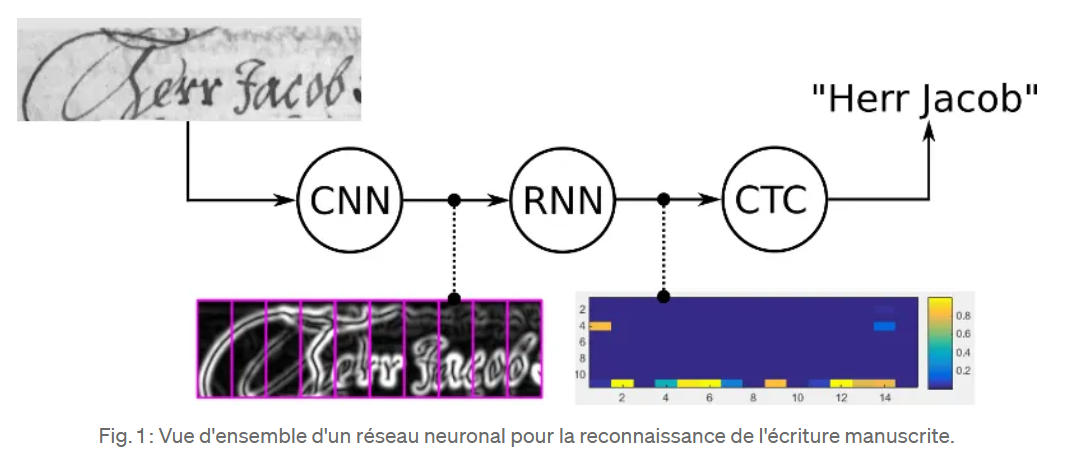

## Importation

**TensorFlow est le moteur de calcul :**

- il manipule des tensors (tableaux de nombres),
- exécute les calculs rapidement (CPU / GPU),
- calcule automatiquement les gradients pour l’apprentissage.

C’est ce qui fait tourner le réseau

**Keras est l’outil de construction :**

- il fournit des couches (CNN, LSTM, Dense…),
- permet d’assembler un modèle,
- gère l’entraînement et les prédictions.

C’est ce qui permet de créer et entraîner le réseau facilement.

In [26]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import zipfile
import tensorflow as tf
import keras
from keras import ops
from keras import layers # pour construire les couches

In [27]:
# !curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
# with zipfile.ZipFile("./captcha_images_v2.zip", "r") as zip_ref:
#     zip_ref.extractall("../data/")

Ce code sert à préparer le dataset CAPTCHA pour l’OCR :
- localiser les images
- extraire les labels (le texte du CAPTCHA)
- analyser les caractères possibles
- définir les paramètres clés pour le modèle CNN + RNN + CTC

Le batch size, c’est le nombre d’exemples traités en même temps par le réseau avant de mettre à jour les poids.

Le modèle prend batch_size images

- Il fait le forward pass
- Il calcule la loss
- Il fait le backpropagation
- Il met à jour les poids
- Puis il passe au batch suivant

Le facteur de sous-échantillonnage "downsample_factor" correspond à la réduction spatiale induite par les couches convolutionnelles et de pooling. Il détermine la longueur de la séquence traitée par le réseau récurrent.”

In [ ]:
import numpy as np
from pathlib import Path

# ================= LOAD DATASET =================

data_dir = Path("../data/all_captcha_png_shuffled/")

all_images = sorted(list(data_dir.glob("*.png")))
all_labels = [img.stem.lower() for img in all_images]  # 👈 IMPORTANT

print("Total images disponibles :", len(all_images))


# ================= SAMPLE 10K =================

np.random.seed(42)

N_SAMPLES = 10_000
n = min(N_SAMPLES, len(all_images))

indices = np.random.choice(len(all_images), size=n, replace=False)

images = np.array([str(all_images[i]) for i in indices])
labels = np.array([all_labels[i] for i in indices])

print("Images utilisées :", len(images))


# ================= SHUFFLE =================

perm = np.random.permutation(len(images))
images = images[perm]
labels = labels[perm]


# ================= SPLIT 80 / 20 =================

split_idx = int(0.8 * len(images))

train_images = images[:split_idx]
train_labels = labels[:split_idx]

test_images = images[split_idx:]
test_labels = labels[split_idx:]

print("Train images :", len(train_images))
print("Test images  :", len(test_images))


# ================= VOCAB =================
# Vocab FIXE → pas d'UNK → CTC stable

characters = list("0123456789abcdefghijklmnopqrstuvwxyz")
num_chars = len(characters)  # 36

num_classes = len(characters)

print("Nombre de caractères :", num_classes)
print("Vocabulaire :", characters)


# ================= PARAMS =================

batch_size = 16

img_width = 200
img_height = 50

downsample_factor = 4

max_length = max(len(label) for label in train_labels)

print("Longueur max label :", max_length)


Total images disponibles : 122491
Images utilisées : 10000
Train images : 8000
Test images  : 2000
Nombre de caractères : 36
Vocabulaire : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Longueur max label : 6


encoder les caractères, Les réseaux de neurones ne comprennent que des nombres.

In [ ]:
# ================= VOCAB & MAPPINGS (CTC SAFE) =================

# Liste des caractères autorisés
characters = list("0123456789abcdefghijklmnopqrstuvwxyz")

# Mapping char -> int (indices 1..36, 0 réservé)
# char -> int : 0..35
char_to_num = layers.StringLookup(
    vocabulary=characters,
    mask_token=None,
    oov_token=None,
    output_mode="int"
)


# Mapping int -> char (SANS StringLookup, SANS UNK)
# Index 0 correspond à '0', donc on décodera avec (index - 1)
num_to_char = tf.constant(characters)


décoder les prédictions, Pour lire la sortie du modèle et afficher le texte prédit

In [30]:
# # Mapping integers back to original characters
# num_to_char = layers.StringLookup(
#     vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
# )

séparer train / validation (il faudra faire un test plus tard)

In [31]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = ops.arange(size)
    if shuffle:
        indices = keras.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

encode_single_sample =  préparer UNE image, Elle transforme une image brute + son texte en entrée utilisable par le modèle.

In [32]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = ops.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = ops.transpose(img, axes=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [33]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(
        batch_size,
        padded_shapes={
            "image": [img_width, img_height, 1],
            "label": [None],
        },
        padding_values={
    "image": tf.constant(0.0, dtype=tf.float32),
    "label": tf.constant(-1, dtype=tf.int64),  # 🔥 CRUCIAL
}
,
    )
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(
        batch_size,
        padded_shapes={
            "image": [img_width, img_height, 1],
            "label": [None],
        },
        padding_values={
    "image": tf.constant(0.0, dtype=tf.float32),
    "label": tf.constant(-1, dtype=tf.int64),  # 🔥 CRUCIAL
}
,
    )
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


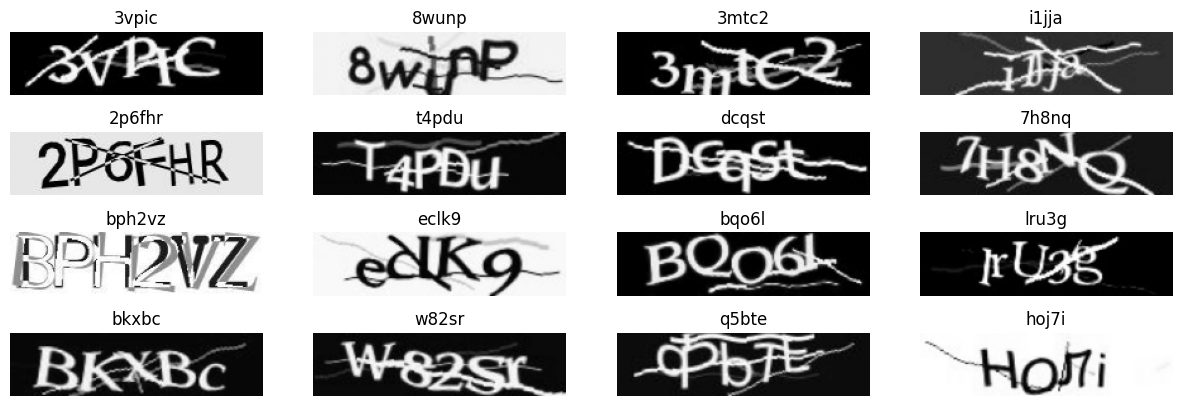

In [34]:
for batch in train_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    fig, ax = plt.subplots(4, 4, figsize=(15, 5))

    for i in range(16):
        # image
        img = (batch_images[i, :, :, 0] * 255).numpy().astype("uint8")
        img = img.T  # on remet la bonne orientation

        # label ground truth (sans padding)
        label_idx = tf.boolean_mask(batch_labels[i], batch_labels[i] >= 0)
        label = tf.strings.reduce_join(
            tf.gather(num_to_char, label_idx - 1)
        ).numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

    plt.show()


- ctc_batch_cost : Calculer la CTC loss, c’est-à-dire mesurer à quel point la prédiction du modèle correspond au vrai texte, sans savoir où sont les caractères dans l’image.

In [35]:
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = ops.cast(ops.squeeze(label_length, axis=-1), dtype="int32")
    input_length = ops.cast(ops.squeeze(input_length, axis=-1), dtype="int32")
    sparse_labels = ops.cast(
        ctc_label_dense_to_sparse(y_true, label_length), dtype="int32"
    )

    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())

    return ops.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )

def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = ops.shape(labels)
    num_batches_tns = ops.stack([label_shape[0]])
    max_num_labels_tns = ops.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return ops.expand_dims(ops.arange(ops.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = ops.cast(tf.fill([1, label_shape[1]], 0), dtype="bool")
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]
    
    dense_mask = tf.logical_and(
    dense_mask,
    labels >= 0
)

    label_array = ops.reshape(
        ops.tile(ops.arange(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = ops.transpose(
        ops.reshape(
            ops.tile(ops.arange(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = ops.transpose(
        ops.reshape(ops.concatenate([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        ops.cast(indices, dtype="int64"), 
        vals_sparse, 
        ops.cast(label_shape, dtype="int64")
    )

Image
 1. CNN (voir les formes)
 2. Reshape (image → séquence)
 3. RNN (lire la séquence)
 4. Softmax (probabilités de caractères)
 5. CTC (comparer au vrai mot)


1. CNN — extraction de caractéristiques visuelles

Le CNN est composé de plusieurs blocs de convolution et de pooling.

Couches de convolution (Conv2D) :
détectent des motifs locaux dans l’image (bords, courbes, traits de lettres).

Couches de pooling (MaxPooling) :
réduisent la taille de l’image tout en conservant l’information importante, ce qui rend le modèle plus robuste et plus rapide.

À la sortie du CNN, l’image est transformée en une carte de caractéristiques riche, mais encore spatiale.

2. Reshape — transformation image → séquence

Le reshape transforme la sortie 2D du CNN en une séquence 1D.

Chaque colonne de l’image (après CNN) devient un pas de temps

Chaque pas de temps est décrit par un vecteur de caractéristiques

Cette étape est indispensable pour permettre au RNN de lire l’image de gauche à droite.

3. RNN (BiLSTM) — modélisation de la séquence

Le RNN traite la séquence produite par le reshape.

Il lit la séquence dans l’ordre temporel

En version bidirectionnelle, il utilise le contexte à gauche et à droite

Il apprend les dépendances entre caractères voisins

À la sortie du RNN, on obtient une représentation contextuelle à chaque pas de temps.

4. Dense + Softmax — probabilités de caractères

La couche Dense projette chaque pas de temps vers l’espace des caractères possibles.

Softmax transforme les scores en probabilités

Pour chaque pas de temps, on obtient une distribution de probabilité sur :

chaque caractère du vocabulaire

le symbole blank

Cette sortie représente ce que le modèle pense voir à chaque position.

5. CTC — comparaison avec le mot réel

La CTC loss compare la séquence de probabilités produite par le modèle avec le mot réel.

Elle ne suppose aucun alignement caractère–image

Elle autorise répétitions et blancs

Elle pénalise le modèle uniquement si le mot réel est improbable ou impossible à obtenir

Cette loss permet l’apprentissage sans segmentation explicite des caractères.

In [36]:


class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = ops.cast(ops.shape(y_true)[0], dtype="int64")

        # longueur des prédictions (temps)
        input_length = ops.cast(ops.shape(y_pred)[1], dtype="int64")
        input_length = input_length * ops.ones(shape=(batch_len, 1), dtype="int64")

        # 🔥 VRAIE longueur des labels (ignore padding -1)
        label_length = ops.sum(
            ops.cast(y_true >= 0, dtype="int64"),
            axis=1,
            keepdims=True
        )

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred



def build_model():
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input_img)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 1))(x)  # 🔥 crucial

    new_shape = ((img_width // 4), (img_height // 2) * 128)
    x = layers.Reshape(target_shape=new_shape)(x)

    x = layers.Dense(128, activation="relu")(x)

    x = layers.Bidirectional(
        layers.LSTM(256, return_sequences=True)
    )(x)
    x = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True)
    )(x)

    x = layers.Dense(len(characters) + 1, activation="softmax")(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output
    )

    model.compile(optimizer=keras.optimizers.Adam(1e-3))
    return model



# Get the model
model = build_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 200, 50,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 100, 25,   │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 100, 25,   │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 50, 25,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 50, 3200)  │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 50, 128)   │    409,728 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 50, 512)   │    788,480 │ dense_4[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 50, 256)   │    656,384 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 50, 37)    │      9,509 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 37)    │          0 │ label[0][0],      │
│                     │                   │            │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,938,597 (7.40 MB)

 Trainable params: 1,938,597 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
print("===== VOCAB CHECK =====")
print("char_to_num vocab :", char_to_num.get_vocabulary())

print("\n===== NUM_TO_CHAR CHECK =====")
print("indices [0,1,2,10] ->", tf.gather(num_to_char, [0, 1, 2, 10]).numpy())

print("\n===== DATASET CHECK =====")
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]

    print("image shape :", images.shape)
    print("label shape :", labels.shape)
    print("min label  :", tf.reduce_min(labels).numpy())
    print("max label  :", tf.reduce_max(labels).numpy())

    # sécurité absolue : aucun 0 dans les labels
    tf.debugging.assert_none_equal(labels, tf.constant(0, dtype=tf.int64))

    # padding = -1
    tf.debugging.assert_less_equal(
    tf.reduce_min(labels),
    tf.constant(-1, dtype=tf.int64)
)


print("\n===== ENCODING CHECK =====")
test_label = tf.constant("a9z")
encoded = char_to_num(tf.strings.unicode_split(test_label, "UTF-8"))
print("test label :", test_label.numpy())
print("encoded    :", encoded.numpy())

print("\n✅ SANITY CHECK PASSED — READY TO TRAIN")


===== VOCAB CHECK =====
char_to_num vocab : [None, np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z')]

===== NUM_TO_CHAR CHECK =====
indices [0,1,2,10] -> [b'0' b'1' b'2' b'a']

===== DATASET CHECK =====
image shape : (16, 200, 50, 1)
label shape : (16, 6)
min label  : -1
max label  : 36

===== ENCODING CHECK =====
test label : b'a9z'
encoded    : [11 10 36]

✅ SANITY CHECK PASSED — READY TO TRAIN


In [38]:
# ================= TRAINING CONFIG =================

epochs = 50
early_stopping_patience = 10

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=early_stopping_patience,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1,
)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="model/ocr_best.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
)

# ================= TRAIN =================

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr, checkpoint],
)


Epoch 1/50
  1/563 ━━━━━━━━━━━━━━━━━━━━ 28:56 3s/step - loss: 2505.4036

InvalidArgumentError: Graph execution error:

Detected at node functional_2_1/ctc_loss_1/CTCLoss defined at (most recent call last):
  File "C:\Users\jbche\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\jbche\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\ipykernel\kernelapp.py", line 758, in start

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\tornado\platform\asyncio.py", line 211, in start

  File "C:\Users\jbche\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever

  File "C:\Users\jbche\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1899, in _run_once

  File "C:\Users\jbche\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\ipykernel\utils.py", line 71, in preserve_context

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\ipykernel\kernelbase.py", line 614, in shell_main

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_shell

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\ipykernel\ipkernel.py", line 366, in execute_request

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\ipykernel\kernelbase.py", line 827, in execute_request

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\ipykernel\ipkernel.py", line 458, in do_execute

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\ipykernel\zmqshell.py", line 663, in run_cell

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3077, in run_cell

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3132, in _run_cell

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3336, in run_cell_async

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3519, in run_ast_nodes

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code

  File "C:\Users\jbche\AppData\Local\Temp\ipykernel_37252\2624931143.py", line 31, in <module>

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 399, in fit

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 241, in function

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 154, in multi_step_on_iterator

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 125, in wrapper

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 134, in one_step_on_data

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 59, in train_step

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\layers\layer.py", line 941, in __call__

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\ops\operation.py", line 59, in __call__

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\models\functional.py", line 183, in call

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\ops\function.py", line 206, in _run_through_graph

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\models\functional.py", line 644, in call

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\layers\layer.py", line 941, in __call__

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\ops\operation.py", line 59, in __call__

  File "c:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\jbche\AppData\Local\Temp\ipykernel_37252\594930139.py", line 20, in call

  File "C:\Users\jbche\AppData\Local\Temp\ipykernel_37252\1514346064.py", line 11, in ctc_batch_cost

Saw a non-null label (index >= num_classes - 1) following a null label, batch: 6 num_classes: 37 labels: 6,15,36,24,33 labels seen so far: 6,15
	 [[{{node functional_2_1/ctc_loss_1/CTCLoss}}]] [Op:__inference_multi_step_on_iterator_21107]

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 25, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 25, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 768)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 50, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 50, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 38)         │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 434,918 (1.66 MB)

 Trainable params: 434,918 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


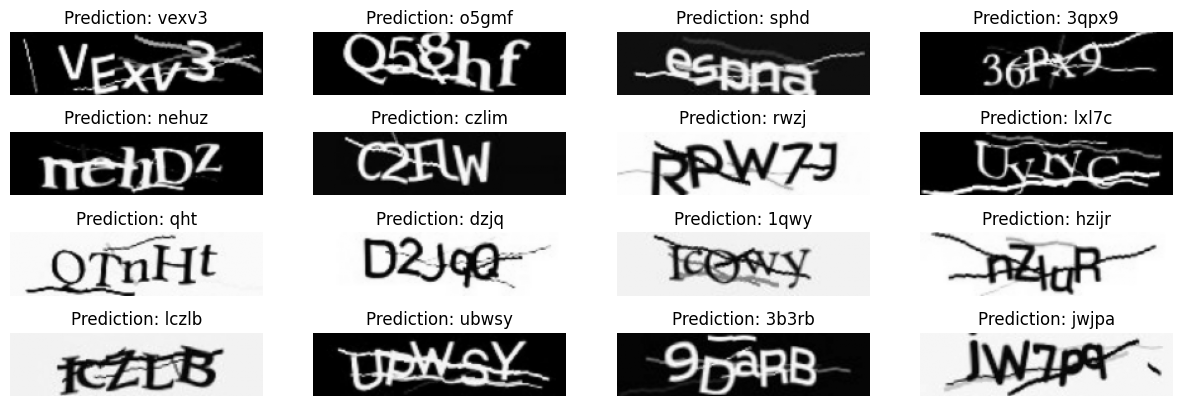

In [ ]:
def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = ops.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())
    input_length = ops.cast(input_length, dtype="int32")

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)


# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)
prediction_model.summary()


# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = ctc_decode(
    pred,
    input_length=input_len,
    greedy=False,
    beam_width=10
)[0][0]


    output_text = []    
    for res in results:
        res = tf.gather(res, tf.where(res > 0))[:, 0]  # enlève padding + blank
        chars = tf.gather(num_to_char, res)
        text = tf.strings.reduce_join(chars).numpy().decode("utf-8")
        output_text.append(text)

    return output_text



#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label_idx = tf.boolean_mask(label, label >= 0)
        text = tf.strings.reduce_join(
            tf.gather(num_to_char, label_idx - 1)
        ).numpy().decode("utf-8")
        orig_texts.append(text)


    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
def levenshtein(a, b):
    n, m = len(a), len(b)
    if n > m:
        a, b = b, a
        n, m = m, n

    current = list(range(n + 1))
    for i in range(1, m + 1):
        previous, current = current, [i] + [0] * n
        for j in range(1, n + 1):
            add, delete = previous[j] + 1, current[j - 1] + 1
            change = previous[j - 1]
            if a[j - 1] != b[i - 1]:
                change += 1
            current[j] = min(add, delete, change)

    return current[n]


def evaluate_ocr(
    prediction_model,
    validation_dataset,
    num_to_char,
    max_length,
):
    total_chars = 0
    total_errors = 0
    exact_matches = 0
    total_samples = 0

    for batch in validation_dataset:
        images = batch["image"]
        labels = batch["label"]

        preds = prediction_model.predict(images, verbose=0)
        pred_texts = decode_batch_predictions(preds)

        true_texts = []
        for label in labels:
            label_idx = tf.boolean_mask(label, label >= 0)
            text = tf.strings.reduce_join(
                tf.gather(num_to_char, label_idx - 1)
            ).numpy().decode("utf-8")
            true_texts.append(text)

        for true, pred in zip(true_texts, pred_texts):
            dist = levenshtein(true, pred)

            total_errors += dist
            total_chars += len(true)
            exact_matches += int(true == pred)
            total_samples += 1

    cer = total_errors / total_chars
    exact_acc = exact_matches / total_samples

    return {
        "CER": cer,
        "Character Accuracy": 1 - cer,
        "Exact Match Accuracy": exact_acc,
    }


metrics = evaluate_ocr(
    prediction_model,
    validation_dataset,
    num_to_char,
    max_length,
)

print(" OCR Performance")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


 OCR Performance
CER: 0.4198
Character Accuracy: 0.5802
Exact Match Accuracy: 0.0550


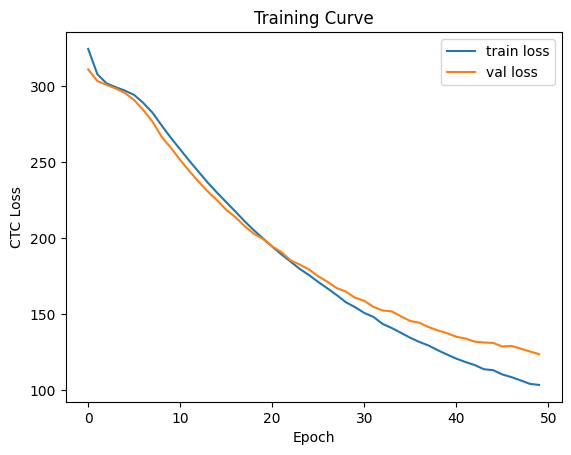

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("CTC Loss")
plt.title("Training Curve")
plt.show()


In [ ]:
# ================= TEST SUR UNE IMAGE =================

import tensorflow as tf
from pathlib import Path

# 👉 CHANGE JUSTE CE PATH
IMAGE_PATH = Path("../data/all_captcha_png_shuffled/zzohd.png")

# --- preprocessing (identique au training) ---
def preprocess_single_image(img_path):
    # Lecture en bytes (safe Windows)
    img_bytes = Path(img_path).read_bytes()

    img = tf.io.decode_png(img_bytes, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])  # width = time
    img = tf.expand_dims(img, axis=0)        # batch
    return img



# --- inference ---
img = preprocess_single_image(IMAGE_PATH)

preds = prediction_model.predict(img, verbose=0)

pred_text = decode_batch_predictions(preds, num_to_char)[0]

print("Image :", IMAGE_PATH.name)
print("GT    :", IMAGE_PATH.stem)
print("Pred  :", pred_text)

TypeError: decode_batch_predictions() takes 1 positional argument but 2 were given